In [92]:

''' Standard Imports '''
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

''' SNS Imports '''
from NetworkGeneration import STDPNetworkGenerator
from sns_toolbox.renderer import render
from sns_toolbox.neurons import SpikingNeuron
from sns_toolbox.connections import SpikingSynapse

''' MuJoCo Imports '''
import mujoco as mj
import mediapy as media

''' Other Misc Imports '''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from random import Random, randint

''' Make the plots pretty and slooooooow '''
mpl.rcParams['figure.dpi'] = 600

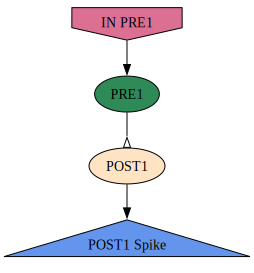

In [93]:


pre_neuron = SpikingNeuron(
    threshold_proportionality_constant=0.0,
    threshold_initial_value=1.0
)
post_neuron = SpikingNeuron(
    threshold_proportionality_constant=0.0,
    threshold_initial_value=1.0
)
synapse = SpikingSynapse(
    reversal_potential=2.0,
    max_conductance=3.0
)

STDP_PRE_NUM = 1
STDP_POST_NUM = 1

net = STDPNetworkGenerator(presynaptic_type=pre_neuron, postsynaptic_type=post_neuron, presynaptic_neurons=STDP_PRE_NUM, postsynaptic_neurons=STDP_POST_NUM, synapse_type=synapse)

render(net)

In [94]:

# Takes spike data string, returns frequency of spikes
def getFreq(data, dt):
    loc = np.where(data == 1)[0]
    freq = []
    for i in range(len(loc)-1):
        freq.append(1 / ((loc[i+1] - loc[i]) * (dt * 0.001)))
    # The first element needs to be removed because this is inner spike, so more spikes than frequencies recorded
    loc = loc[1:] * dt
    return freq, loc

In [95]:

def randConnections(pre_num, post_num, seed=None, g_min=1.00, g_max=5.98):
    if seed is not None:
        rng = Random(x=seed)
    else:
        rng = Random()
    '''
    For Conductances
    2.99 is a barely spikes the post when paired.
    g_max is for solo spiking. 
    '''
    g_min = int(g_min * 100) # Convert to int
    g_max = int(g_max * 100) # Convert to int

    # Empty matrix for conductivity parameters
    matrix = np.zeros([pre_num + post_num, pre_num + post_num])

    for pre in range(0, pre_num):
        for post in range(pre_num, pre_num + post_num):
            matrix[post, pre] = (rng.randint(g_min, g_max) / 100)
    
    return matrix

In [96]:
dt = 0.1
tmax = 10000
t = np.arange(0, tmax, dt)

''' New additions to be passed to compilier '''
ltp_a = 0.007
ltp_t = 10.0
ltd_a = 0.011
ltd_t = 4.5
max_condutance = 6.0

RANDOMIZED_CONDUCTIVITY = randConnections(STDP_PRE_NUM, STDP_POST_NUM, g_min=5.9)

c = net.compile(dt=dt, backend='numpy', debug=False,
                STDP_PRE=STDP_PRE_NUM, STDP_POST=STDP_POST_NUM,
                STDP_LTP_A=ltp_a, STDP_LTP_T=ltp_t, STDP_LTD_A=ltd_a, STDP_LTD_T=ltd_t,
                MAX_CONDUCTIVITY=max_condutance)

print(c.__dict__.get('g_max_spike'))
# print(c.g_increment)
print(c.g_max_spike[STDP_PRE_NUM:, 0:STDP_PRE_NUM])
# print(c.__dict__.get('pre_spike_diff'))
# print(c.__dict__.get('post_spike_diff'))

[[0. 0.]
 [3. 0.]]
[[3.]]


In [97]:
inputs = np.zeros([len(t), net.get_num_inputs()])

inputs[:, 0] = 1.6
# inputs[:, 1] = 1.8
# inputs[:, 2] = 1.4
# inputs[:, 3] = 1.4

# inputs[4000:8000, 2] = 0
# inputs[4000:8000, 3] = 0

data = np.zeros([len(t), net.get_num_outputs_actual()])

g_track = np.zeros(shape=[len(t), STDP_POST_NUM, STDP_PRE_NUM])

for i in range(len(t)):
    if i == 0:
        data[i, :] = c(inputs[i, :], current_time=t[i], dt=dt, g_update=RANDOMIZED_CONDUCTIVITY)
    else:
        data[i, :] = c(inputs[i, :], current_time=t[i], dt=dt)

    g_track[i] = c.g_max_spike[STDP_PRE_NUM:, 0:STDP_PRE_NUM]

    
data = data.transpose()

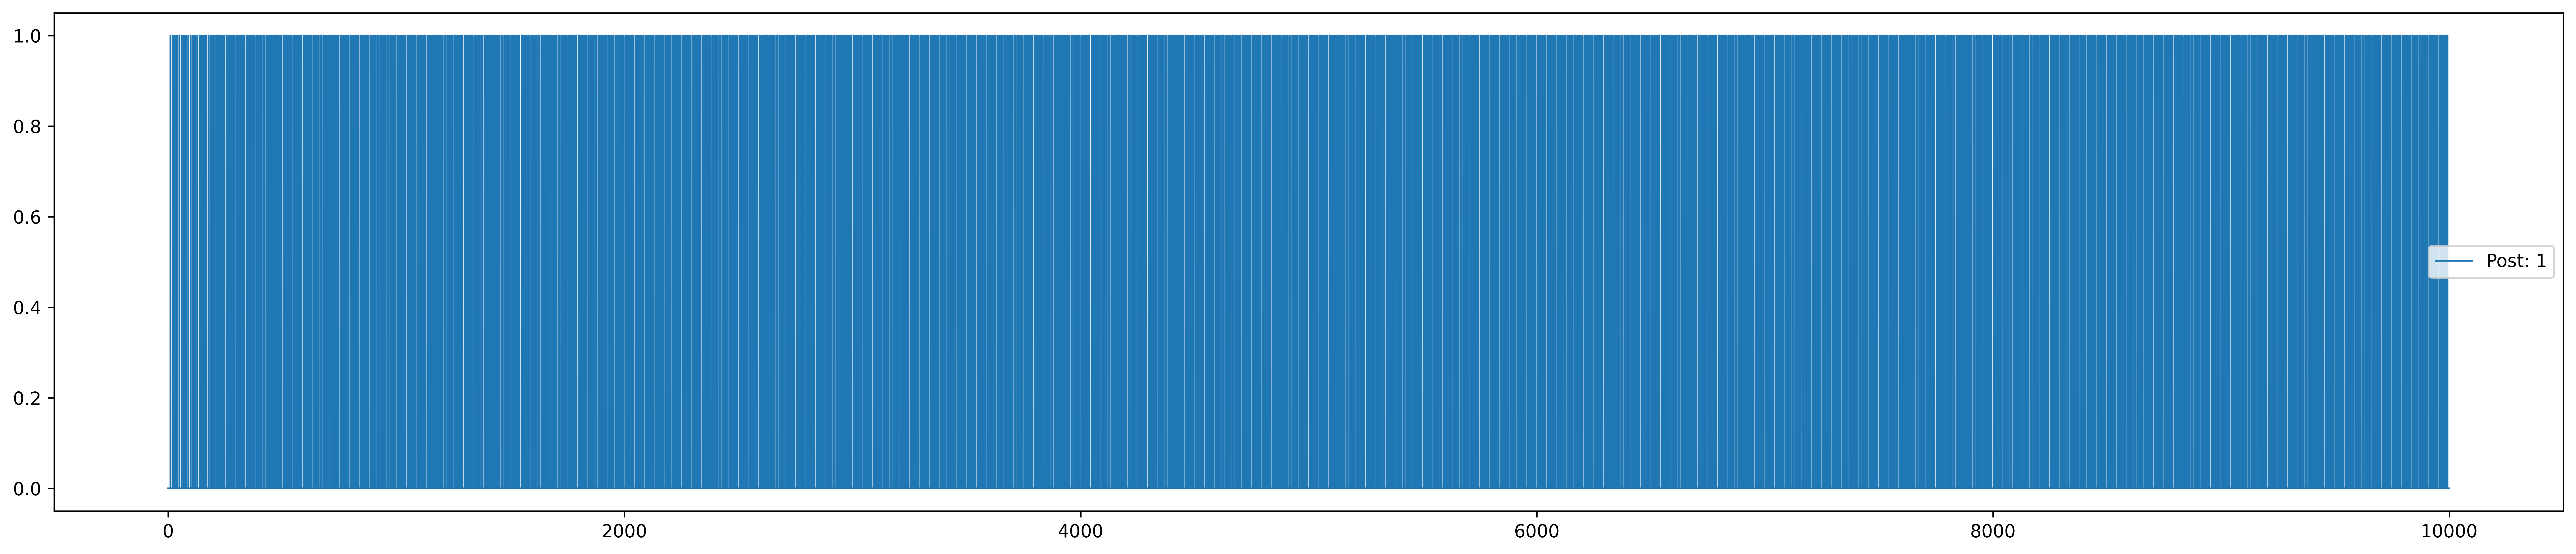

In [98]:
plt.figure(figsize=[25, 5])
for i in range(net.get_num_outputs_actual()):
    plt.plot(t, data[i,:] * (1 - 0.05*i), linewidth='1', label=('Post: ' + str(i + 1)))
plt.legend()
plt.show()

In [99]:
plt.figure(figsize=[25, 10])
for i in range(net.get_num_outputs_actual()):
    freq, loc = getFreq(data=data[i,:], dt=dt)
    print(np.mean(freq))
    plt.plot(loc, freq, label=('Post: ' + str(i + 1)))
plt.ylim([0, 250])
plt.legend()
plt.show()

141.9160641413961


In [100]:
print(c.__dict__.get('g_max_spike'))
print(c.__dict__.get('g_increment'))

print(c.g_max_spike[STDP_PRE_NUM:, 0:STDP_PRE_NUM])

[[0.         0.        ]
 [5.98966551 0.        ]]
[[0.         0.        ]
 [5.98966551 0.        ]]
[[5.98966551]]


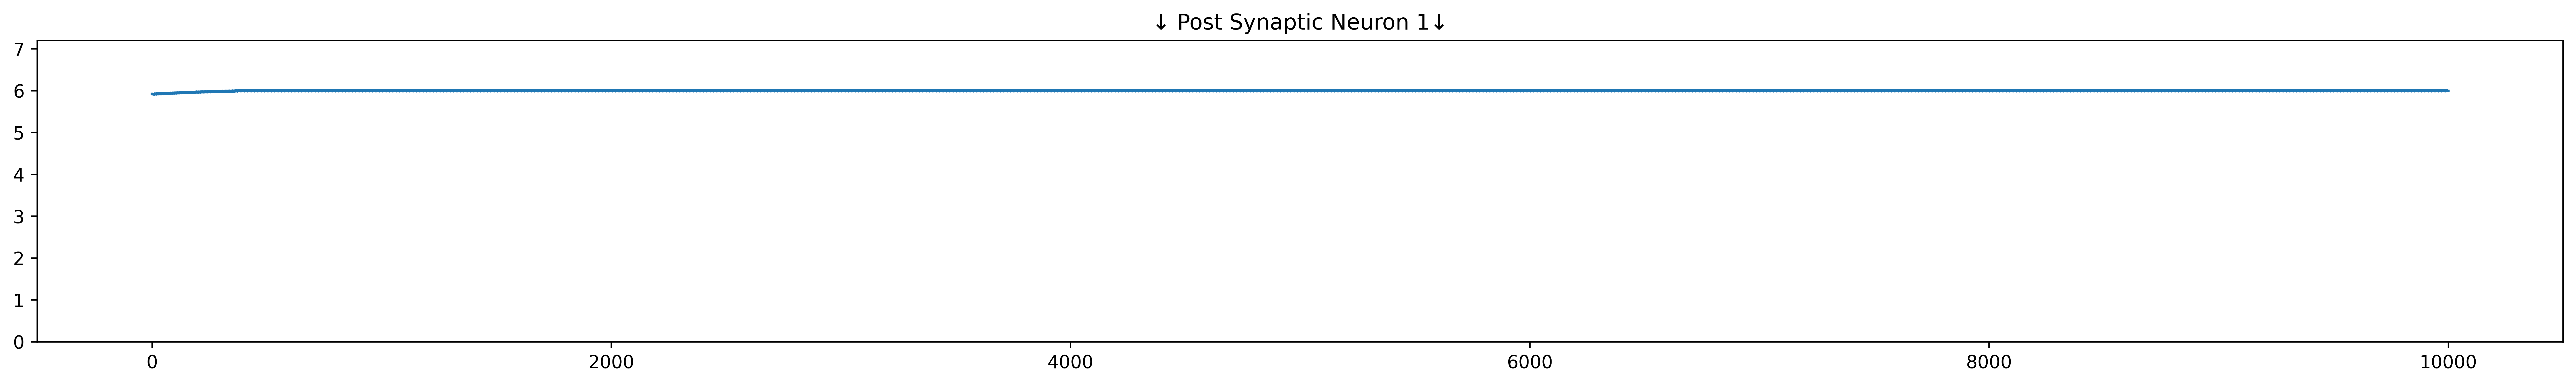

In [101]:
plt.figure(figsize=[25, STDP_POST_NUM * 3])

for post in range(STDP_POST_NUM):
    plt.subplot(STDP_POST_NUM, 1, post + 1)
    plt.title('↓ Post Synaptic Neuron ' + str(post + 1) + '↓')
    for pre in range(STDP_PRE_NUM):
        plt.plot(t, g_track[:, post, pre])
        plt.ylim([0, max_condutance * 1.2])
        
plt.subplots_adjust(hspace=0.5)
plt.show()